# Empirical analysis of ROC-AUC
- Exploration of ROC curve and AUROC by generating different case studies
- Build intuition using figures of how ROC maps stuff and how the underlying distributions look like
- Ablations on AUROC invariances

## 0. Data
- Generate binary classification data
- Draw prediction probabilities from uniform or normal distributions
- Functionality to play around with positioning of classes (overlap, scale, shift)

## 1. Underlying Metrics

- ROC curve is plotted on two dimensions: TPR and FPR
- Here we explore the metrics and their relationship
- Given that multi-class is just an aggregation of multiple binary cases, I will talk about this in the binary setting
- Will be using binary terminology (e.g for detection): identified (TP), missed (FN), rejected (TN), false alarm (FP)
- All ground truth positives are either correctly identified or missed -> P = TP + FN
- All ground truth negatives are either correctly rejected or false alarms -> N = TN + FP

### TPR

- True positive rate (recall) is a measure of how much a classifier can detect (not the quality), or in other words how many things are not missed
- I an simplified case one can construe this as being the capacity/ability of a model e.g how many patterns it can learn
- We want to maximise this*. Has a trivial maximum by predicting everything as positive.

$$ TPR = \frac{TP}{TP+FN} = \frac{TP}{P}$$

- Missed positives = False Negatives
- TP/P can also be seen as the accuracy on ground truth positives TPR = $P(\hat{y} | y=1)$ e.g class specific accuracy
- The complement of TPR (probability of the negative prediction conditioned on true positive class) is FNR


### FPR
- False alarm rate describes it quite well, although can be misinterpreted as being related to precision
    - E.g. FPR=0.4 doesn't mean 40% of predictions are false positives. It means 40% of all negatives have been worngly predicted as positives
- What proportion of negatives have been missed
- Is also a recall-like metric - but conditioned on the negative class
- We want to minimise this*. Has a trivial minimum by predicting everything as negative.

$$ FPR = \frac{FP}{FP+TN} = \frac{FP}{N}$$

- The conditional (denominator) is the negative class so can't add up to 1 with TPR
- FPR = $P(\hat{y}| y=0)$
- The negative class counterpart of TPR would be TNR (specificity), or a "recall" of the negative class
- FPR = 1 - TNR; which is TNR's complement - we can see FPR as measuring how bad the negative class recall is
- For intiuition: instead of minimising FPR, we can think of maximising TNR; 


### Relationship
- Both metrics are conditioned on a ground truth class, not on the predicted class (like precision): TPR wrt positives, FPR wrt negatives.
- Both metrics are a ratio of a ground truth class
- Neither of them is sensitive to class imbalance as they dont take the opposite class into consideration
- Both metrics are recall based so biased towards Type II errors
- TRP is maximised when everything is predicted as positive and FPR when negative

## 1.1 Increasingly overlapping classes
- See how TPR and FPR change as we progressively move the two classes together
- TPR decreases and FPR increases the more mingled the classes become

## 1.2 Different Thresholds
- We don't have to decide something is detected just if the confidence is over 0.5, the threshold is an arbitrary choice
- By choosing an appropriate confidence level we can ensure the classifier has the properties our application needs (e.g maximising for precision or recall)
- For low thresholds we get a maximum recall (TPR) since we are not missing any positives; however the precision on those predictions is quite bad
- The more we increase the threshold the better TPR gets, while FPR decreases
- Notice: whenever there is a gap in support (per class) the metrics will be the same for nearby thresholds -> Flat areas in the metric plots.
    - Because each metric is conditioned on a different class, the moment all elements of one class have been passed the threshold the metric will not change anymore
- Notice: TPR starts decreasing only when we reach the support of the positive class (TPR is conditioned on positives)
- Notice: FPR stops decreasing only when we passed the support of the negative class (FPR is conditioned on negatives)
- Notice: The rate at whcih TPR/FPR decrease depends on the density of ground truth classes
    - See uniform vs normal; for uniform classes the metrics linearly decrease, since the same amount of observations of re-classified at regular intervals. 
    - See similarities with cumulative distribution of the predictions
- The practical threshold selection happens in the region of overlapping supports e.g at the true class boundary which cannot be perfectly predicted.

## 2. ROC Curve
- Plots TPR against FPR
- Insead of seeing it like a 2D plot on can interpret it as a function of recall given false alarm rate
    - e.g how much recall do I get for a chosen, tolerable false alarm rate
- Thresholds: While we can still think of the sliding threshold which produces the rates, the thresholding values are not visible
  - We can plot the ROC curve as a scatterplot and color points based on threshold
  - Looking at the color we see that the ROC curve goes "backwards": low thresholds appear on the right where FPR is high.
  - If any two thresholds produce the same metric values, they will collapse to the same point in the roc plot
  - If two similar thresholds produce very different metric values we will see large gaps between points
- Flat areas: The previously seen flat areas for individual metrics are now either horizontal or vertical:
  - Vertical: FPR stays constant (at 0) means we passed the support of the negative class
  - Horizontal: TPR stays constant (at 1) means we haven't reached the support of the positive class yet
- The X-axis
  - If we see ROC as TPR(FPR) then FPR is the x-axis
  - As with any function the x-axis determines where we look at and at what pace we traverse it
  - Having any recall-based metric as the x-axis means traversing a ground truth class linearly (in terms of nr of samples)
  - Any "Rate" metric represents a % of observations on one side of the threshold to all observations of that class
  - We move away from traversing the threshold space, to traversing the sample space (the order is still defined by the thresholds)
  - By traversing the sample space we make sure that at every x-tick we have passed the same amount of samples
    - traversing by threshold could lead to jumps in nr of samples for small changes in threshold - it all depends on the density of the class
    - we thus remove the shape of the distribution of the class, and traverse it linearly
    - any area with a large mass will be stretched out / zoomed in
  - This also ensures that we exclude areas of the prediction/threshold space where things don't really change in terms of Rates
      - FPR=0 occupies a large portion in the threshold plots (right half) however is reduced to a single point in the ROC space.
  - Having FPR as the x-axis we operate only on thresholds over the ground truth negative class 
    - we don't care what happens below it (max TPR)
    - or above it, where the ground truth positive class is exclusive (max precision)
  - In other words look only at TRPs defined over the support of the negative class
  - The negative class support has two areas: where the negative class is exclusive, and where there is an overlap with positive class
  - Whether one of these areas is focused on depends on where most of the mass of the negative class is
      - if most negative data points have no positives then expect TPR to be maximised for a large part of the FPR space -> large area
      - if most negative data points have positives then expect TPR to decrease for a large part of the FPR space -> the curvy part will be large
- Shape: if there is a clean separation between classes the ROC curve will be square, while a blurr/mix of classes produces a smoother curve

## 3. AUROC
- Area under the ROC curve
- By reducing a vector to a single number we necessarily lose information
- Different ROC curves will inevitably produce the same scores
- Here we explore some invariances of the AUROC wrt the underlying data
- Notice: The right side of the decision space (shaded above), where there is no support for the negative class (FPR=0), does not contribute
- The Area is maximised the fewer positives are on the support of the negative class

### 3.1 Scale Invariance
- We can shrink the support of the dataset/predictions and see if AUROC changes
- AUROC is scale invariant
- ROC traverses the FPR space linearly, regardless of where and how spread out it is
- Because the scaling is uniform all "extra" thresholds will map to the same FPR and TPR anyways, so the ROC curve will remae unchanged
- Thresholds left of the negative class will collapse to FPR=1 (no TN, all negative classes are FP), while thresholds right of the negative class (and positive class) will collapse to FPR=0 (no FP, all negative classes are TN)

### 3.2 Shift Invariance
- We can shift the predictions e.g squeeze them all into [0.5, 1]
- AUROC is shift invariant
- ROC traverses the FPR space linearly, regardless of where and how spread out it is
- Similar to scale invariance, it doesn't really matter where the prediction interval is located, all thresholds left and right of the negative class support will collapse to a single point respectively on the ROC curve; all other thresholds will produce FPR and TRPs that have been seen before as all the ratios are the same

### 3.3. Class Boundary and Margin Sensitivity
- How sensitive is AUROC to different degrees of predictions overlapping
- When there is a clear separation between classes e.g a wide margin, then AUROC maxes out since for all thresholds over the negative class (all posible FPR rates) we always get full recall (all TP)
- AUROC is sensitive to class overlap, proportional to the mass of positives and negatives in that region
- The more negative mass is outside the overlap the less the margin will be zoomed in
- the more positive mass is in the overlap the more TRP will be compromised

### 3.4 Class Imbalance
- AUROC is invariant to class imbalances
- Both TPR and FPR are ratios of their own class e.g TPR is ratio of predicted positives over all positives
- Nothing in AUROC takes into consideration the ratio of one class to the other
- Both metrics are "inward" looking and the ratios will stay the same regardless of how many total positives or negatives there are

## 4. Limitations
- Consequences of the projection and metric choices
- We can mix parameters and find datasets that have different characteristics but the same AUROC
- Two factors influence AUROC: how much negative mass does not have positives; how much positive mass is in the overlap.

# 5. Conclusion
- AUROC measures the expected recall for decision thresholds placed over the negative class support
- The underlying metrics TPR and FPR are class independent and don't provide any information about inter-class ratios, hence its invariance to class imbalance
- The ROC curve displays TPR as a function of FPR; the invidual threshold values are lated. Threshold traversal is non-linear as some intervals are collapsed or expanded, but negative class traversal is linear.
- Depending on where most negative mass is, ROC either zooms in on the exlusive negative zone (max TPR) or on the class boundary
- AUROC is invariant to: scale, shift of the prediction space; and class imbalances
- AUROC it is maximised when there is a clear separation, minimised when classes overlap entirely.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics as sk_metrics
%config Completer.use_jedi = False

## 0. Data
- Generate binary classification data
- Draw prediction probabilities from uniform or normal distributions
- Functionality to play around with positioning of classes (overlap, scale, shift)

In [3]:
def get_data(boundary=0.5, overlap=0.5, class_ratio=0.5, scale=1, shift=0, n_obs=200, dist="uniform") -> pd.DataFrame:
    """
    Generate binary classification data, predictions drawn from uniform or normal distributions
    :param boundary: where the true boundary between the classes should be; can change depending on scale and shift
    :param overlap: percentage of how much the two classes should overlap, can be negative to get a wider margin
    :param class_ratio: to play with class imbalances, refers to primary class (1)
    :param scale: In (0, 1], shrinks support to leave more space on the sides for thresholding; remains centered around the boundary
    :param shift: Move support, works only if support scaled down as it will remain in [0,1]
    :param dist: distribution to draw predictions from - either uniform or normal
    """
    n_pos = int(n_obs * class_ratio)
    n_neg = int(n_obs * (1 - class_ratio))
    eps = 1e-2
    
    dist = np.random.uniform if dist == "uniform" else np.random.standard_normal
    pos = _rescale(dist(size=n_pos), min_=boundary - overlap/2 + eps, max_=1)
    neg = _rescale(dist(size=n_neg), min_=0, max_=boundary + overlap/2 - eps)
    preds = np.concatenate([pos, neg])
    y = [1] * n_pos + [0] * n_neg
    
    scale = min(abs(scale), 1)
    preds = preds * scale + boundary * (1 - scale)
    
    shift = max(shift, -min(preds)) if shift < 0 else min(shift, (1-max(preds)))
    preds += shift
    
    res = pd.DataFrame({"preds": preds, "y": y})
    return res


def _rescale(s: pd.Series, min_: float, max_: float):
    s = (s - s.min()) / (s.max() - s.min())
    s = (max_ - min_) * s + min_
    return s


def plot_data(data, ax=None, title=None, dist="uniform"):
    """
    Plot as a filled histogram, each bar shows the class distribution for bin
    """
    if dist == "uniform":
        ax = sns.histplot(data=data, x="preds", hue="y", bins=20, binrange=(0, 1), multiple="fill", ax=ax)
    else:
        ax = sns.kdeplot(data=data, x="preds", hue="y", ax=ax, bw_adjust=0.7, cut=0.1, fill=True)
    ax.set_xlim(0, 1)
    ax.set_title(title)
    

Uniform


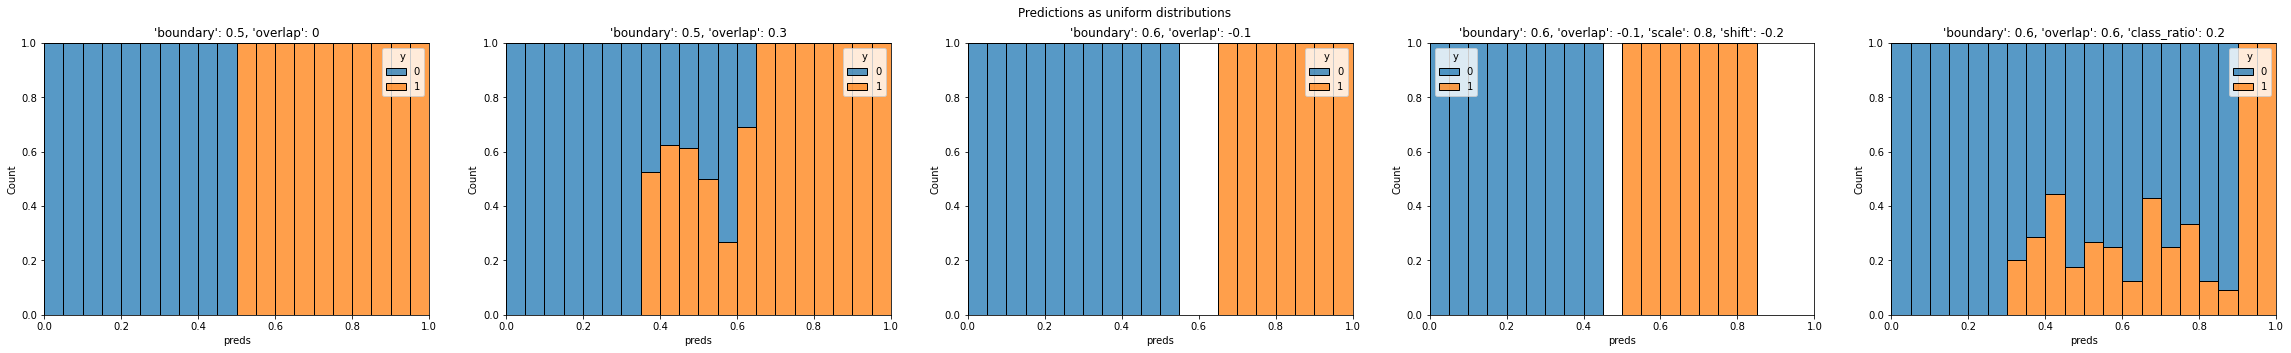

Normal


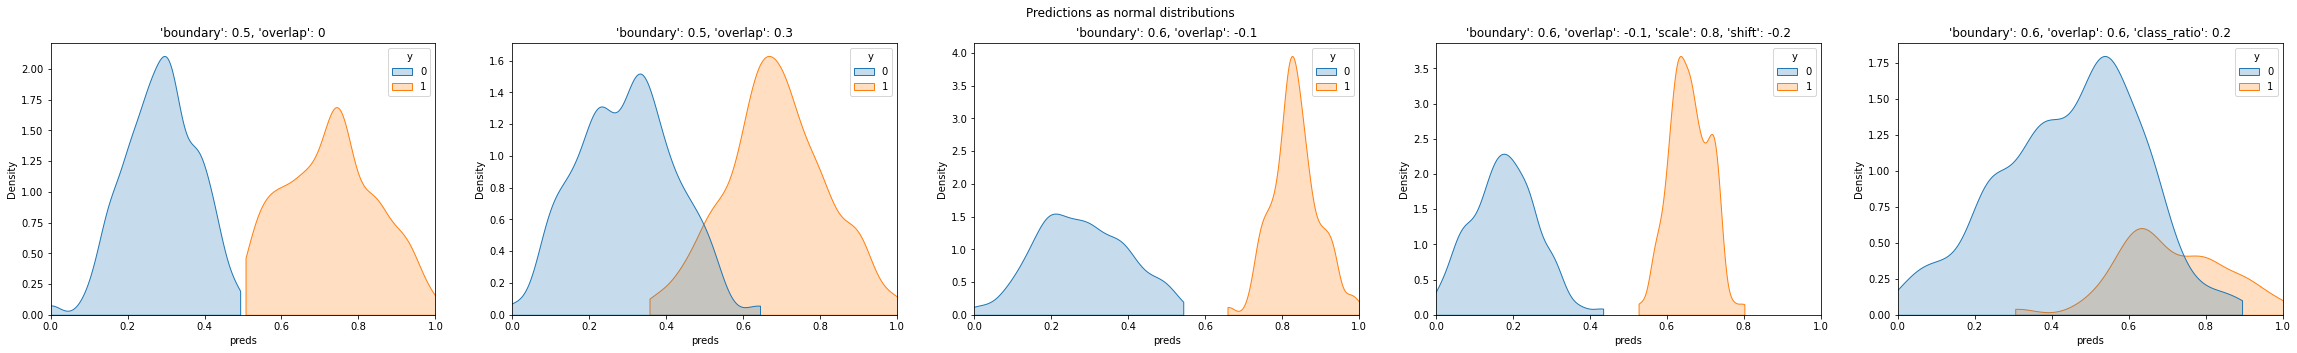

In [408]:
examples = [
        {"boundary": 0.5, "overlap": 0},
        {"boundary": 0.5, "overlap": 0.3},
        {"boundary": 0.6, "overlap": -0.1},
        {"boundary": 0.6, "overlap": -0.1, "scale": 0.8, "shift": -0.2},
        {"boundary": 0.6, "overlap": 0.6, "class_ratio": 0.2},
    ]
print("Uniform")
fig0, axarr = plt.subplots(1, len(examples), figsize=(40,5))
plt.suptitle("Predictions as uniform distributions")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[ix], title=str(params)[1:-1], dist="uniform")
plt.show()
    
print("Normal")
fig, axarr = plt.subplots(1, len(examples), figsize=(40,5))
plt.suptitle("Predictions as normal distributions")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="normal")
    plot_data(data, ax=axarr[ix], title=str(params)[1:-1], dist="normal")
plt.show()


## 1. Underlying Metrics

- ROC curve is plotted on two dimensions: TPR and FPR
- Here we explore the metrics and their relationship
- Given that multi-class is just an aggregation of multiple binary cases, I will talk about this in the binary setting
- Will be using binary terminology (e.g for detection): identified (TP), missed (FN), rejected (TN), false alarm (FP)
- All ground truth positives are either correctly identified or missed -> P = TP + FN
- All ground truth negatives are either correctly rejected or false alarms -> N = TN + FP

### TPR

- True positive rate (recall) is a measure of how much a classifier can detect (not the quality), or in other words how many things are not missed
- I an simplified case one can construe this as being the capacity/ability of a model e.g how many patterns it can learn
- We want to maximise this*. Has a trivial maximum by predicting everything as positive.

$$ TPR = \frac{TP}{TP+FN} = \frac{TP}{P}$$

- Missed positives = False Negatives
- TP/P can also be seen as the accuracy on ground truth positives TPR = $P(\hat{y} | y=1)$ e.g class specific accuracy
- The complement of TPR (probability of the negative prediction conditioned on true positive class) is FNR


### FPR
- False alarm rate describes it quite well, although can be misinterpreted as being related to precision
    - E.g. FPR=0.4 doesn't mean 40% of predictions are false positives. It means 40% of all negatives have been worngly predicted as positives
- What proportion of negatives have been missed
- Is also a recall-like metric - but conditioned on the negative class
- We want to minimise this*. Has a trivial minimum by predicting everything as negative.

$$ FPR = \frac{FP}{FP+TN} = \frac{FP}{N}$$

- The conditional (denominator) is the negative class so can't add up to 1 with TPR
- FPR = $P(\hat{y}| y=0)$
- The negative class counterpart of TPR would be TNR (specificity), or a "recall" of the negative class
- FPR = 1 - TNR; which is TNR's complement - we can see FPR as measuring how bad the negative class recall is
- For intiuition: instead of minimising FPR, we can think of maximising TNR; 


### Relationship
- Both metrics are conditioned on a ground truth class, not on the predicted class (like precision): TPR wrt positives, FPR wrt negatives.
- Both metrics are a ratio of a ground truth class
- Neither of them is sensitive to class imbalance as they dont take the opposite class into consideration
- Both metrics are recall based so biased towards Type II errors
- TRP is maximised when everything is predicted as positive and FPR when negative

In [4]:
def ccacc(data, prediction=1, conditional=1, threshold=0.5):
    """my class conditional accuracy aptly named ccacc, generalisation of TPR, TNR, FPR, FNR"""
    data = data.loc[data["y"] == conditional]
    preds = data["preds"] >= threshold
    if prediction != conditional:
        preds = ~preds
    acc = (preds == data["y"]).mean()
    return acc


def get_metrics(data, n_thresholds=100) -> pd.DataFrame:
    """Dataframe with all metrics and thresholds as index"""
    res = []
    for threshold in np.linspace(0, 1, n_thresholds):
        res.append({
            "threshold": threshold,
            "TPR": ccacc(data, prediction=1, conditional=1, threshold=threshold),
            "FNR": ccacc(data, prediction=0, conditional=1, threshold=threshold),
            "FPR": ccacc(data, prediction=1, conditional=0, threshold=threshold),
            "TNR": ccacc(data, prediction=0, conditional=0, threshold=threshold),
        })
    return pd.DataFrame(res).set_index("threshold")


data = get_data(overlap=0.2)
print("recall me:", ccacc(data, prediction=1, conditional=1, threshold=.5))
print("recall sklearn:", sk_metrics.recall_score(data['y'], data['preds'] >= .5))

recall me: 0.81
recall sklearn: 0.81


## 1.1 Increasingly overlapping classes
- See how TPR and FPR change as we progressively move the two classes together
- TPR decreases and FPR increases the more mingled the classes become

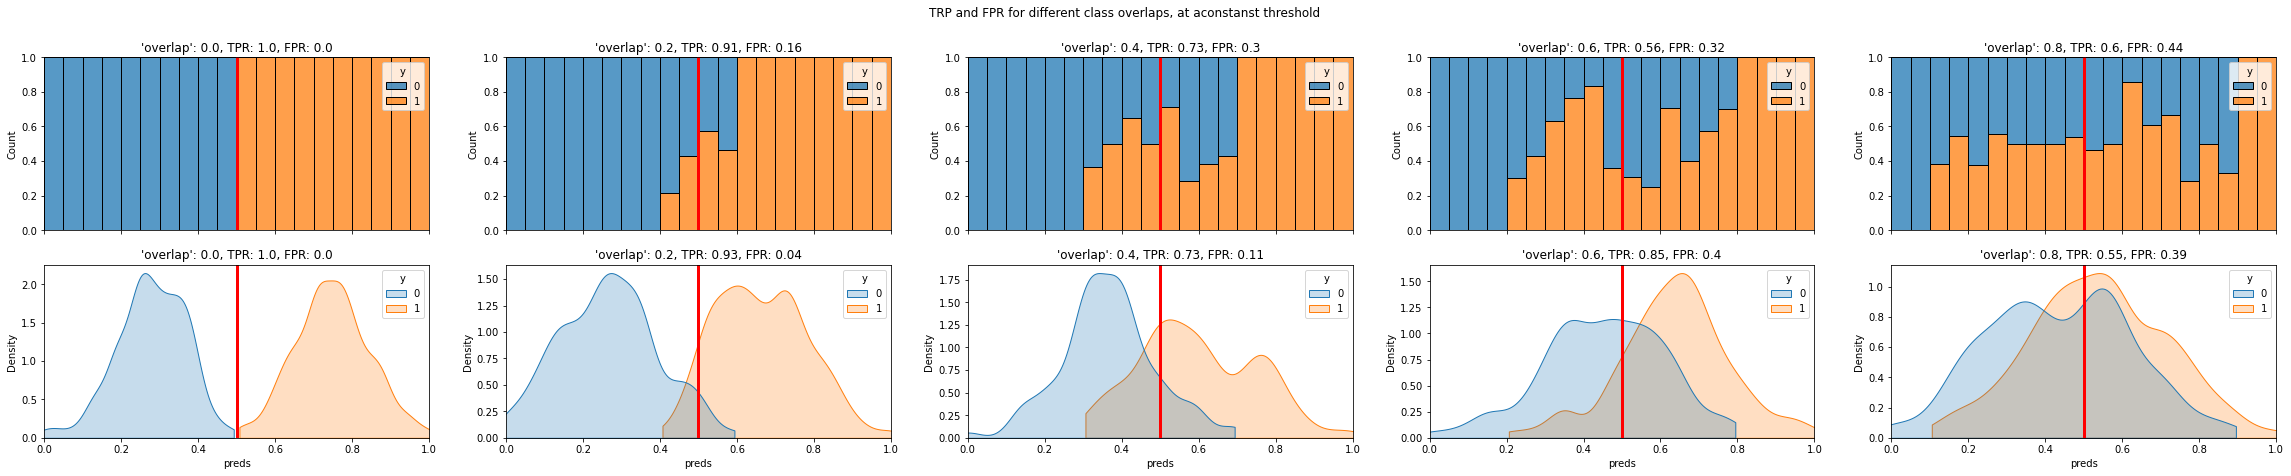

In [639]:
examples = [{"overlap": i/10} for i in range(0, 10, 2)]
fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=True)

for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=f"{str(params)[1:-1]}, TPR: {ccacc(data, prediction=1, conditional=1, threshold=.5)}, FPR: {ccacc(data, prediction=1, conditional=0, threshold=.5)}", dist="uniform")
    axarr[0, ix].axvline(0.5, color="red", linewidth=3)
    
    data = get_data(**params, dist="normal")
    plot_data(data, ax=axarr[1, ix], title=f"{str(params)[1:-1]}, TPR: {ccacc(data, prediction=1, conditional=1, threshold=.5)}, FPR: {ccacc(data, prediction=1, conditional=0, threshold=.5)}", dist="normal")
    axarr[1, ix].axvline(0.5, color="red", linewidth=3)

plt.suptitle("TRP and FPR for different class overlaps, at aconstanst threshold")
plt.show()


## 1.2 Different Thresholds
- We don't have to decide something is detected just if the confidence is over 0.5, the threshold is an arbitrary choice
- By choosing an appropriate confidence level we can ensure the classifier has the properties our application needs (e.g maximising for precision or recall)
- For low thresholds we get a maximum recall (TPR) since we are not missing any positives; however the precision on those predictions is quite bad
- The more we increase the threshold the better TPR gets, while FPR decreases
- Notice: whenever there is a gap in support (per class) the metrics will be the same for nearby thresholds -> Flat areas in the metric plots.
    - Because each metric is conditioned on a different class, the moment all elements of one class have been passed the threshold the metric will not change anymore
- Notice: TPR starts decreasing only when we reach the support of the positive class (TPR is conditioned on positives)
- Notice: FPR stops decreasing only when we passed the support of the negative class (FPR is conditioned on negatives)
- Notice: The rate at whcih TPR/FPR decrease depends on the density of ground truth classes
    - See uniform vs normal; for uniform classes the metrics linearly decrease, since the same amount of observations of re-classified at regular intervals. 
    - See similarities with cumulative distribution of the predictions
- The practical threshold selection happens in the region of overlapping supports e.g at the true class boundary which cannot be perfectly predicted.

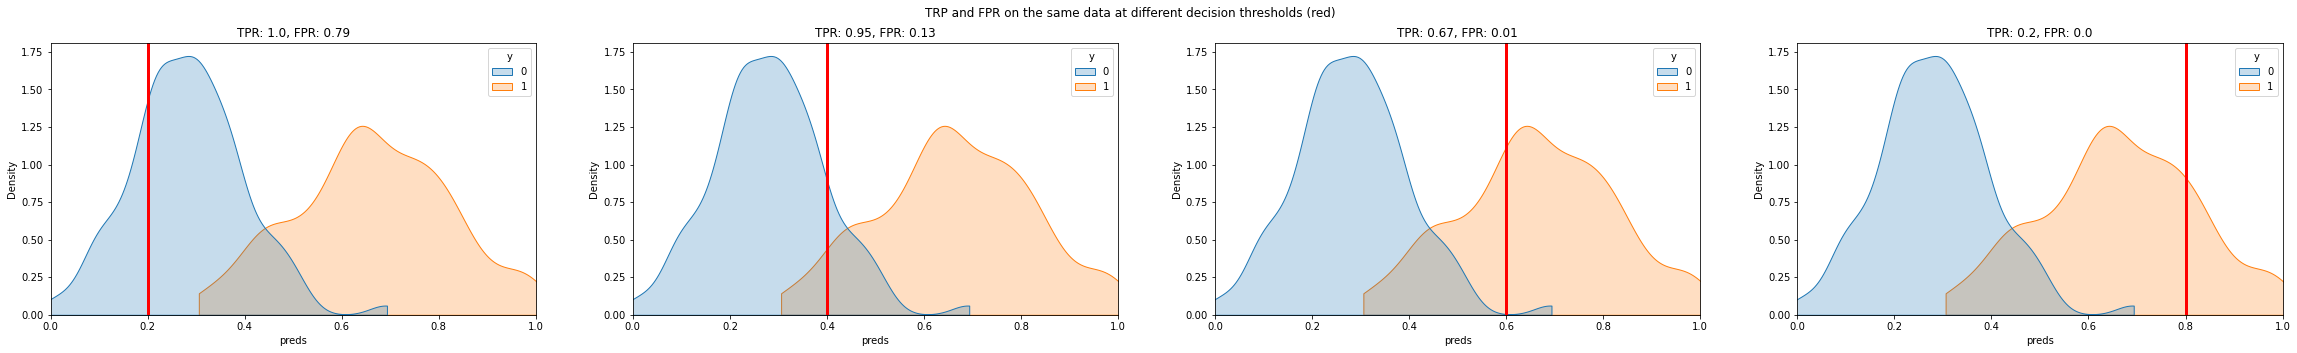

In [422]:
fig, axarr = plt.subplots(1, 4, figsize=(40,5))
data = get_data(overlap=0.4, dist="normal")
for ix, threshold in enumerate(thresholds):
    plot_data(data, ax=axarr[ix], title=f"TPR: {ccacc(data, prediction=1, conditional=1, threshold=threshold)}, FPR: {ccacc(data, prediction=1, conditional=0, threshold=threshold)}", dist="normal")
    axarr[ix].axvline(threshold, color="red", linewidth=3)
plt.suptitle("TRP and FPR on the same data at different decision thresholds (red)")
plt.show()

Uniform


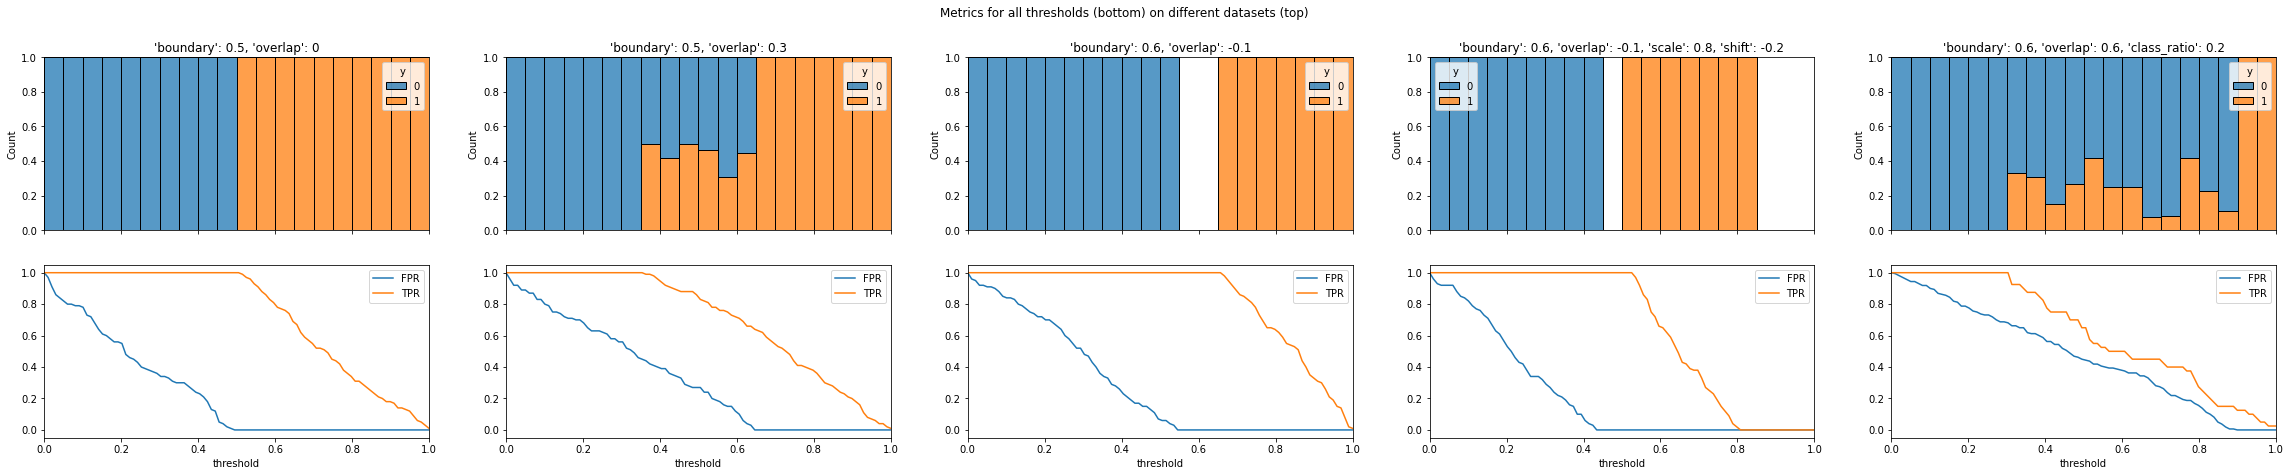

Normal


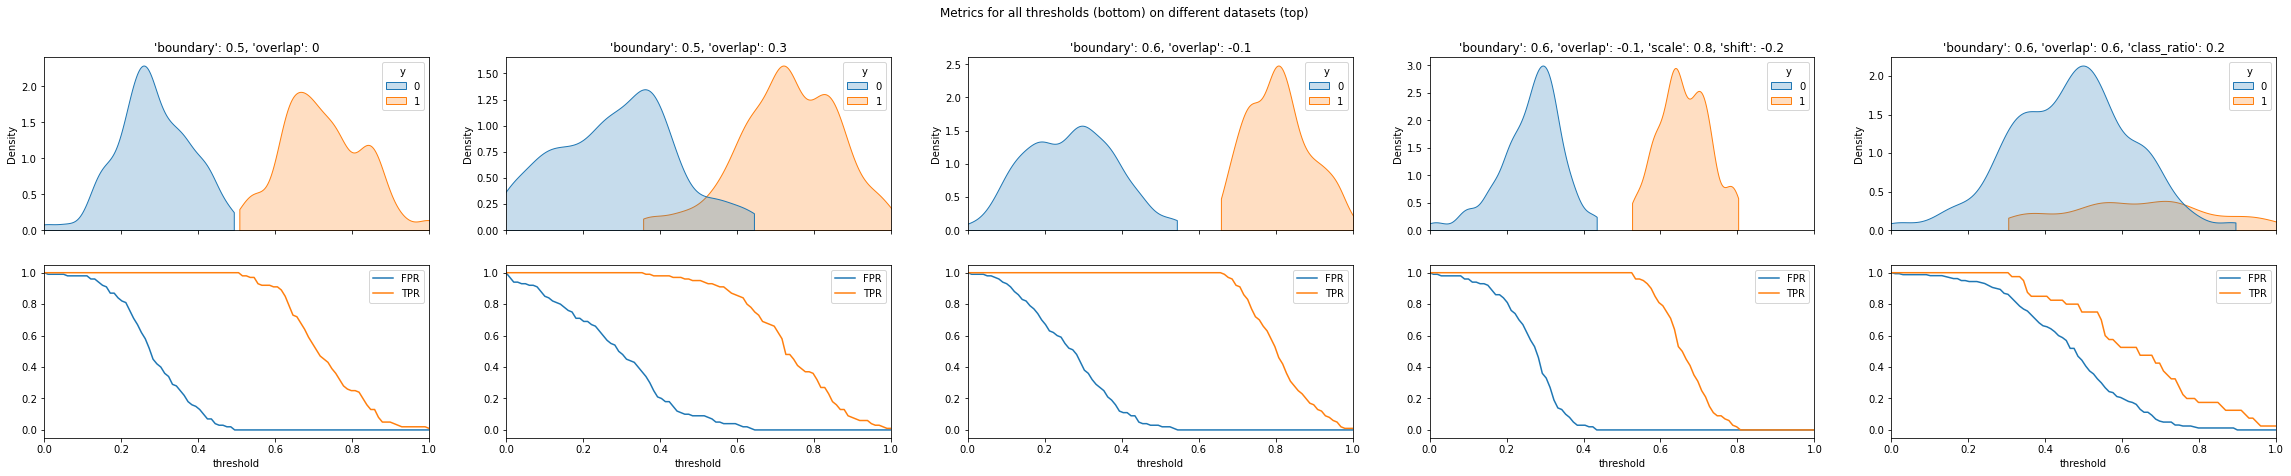

In [426]:
examples = [
        {"boundary": 0.5, "overlap": 0},
        {"boundary": 0.5, "overlap": 0.3},
        {"boundary": 0.6, "overlap": -0.1},
        {"boundary": 0.6, "overlap": -0.1, "scale": 0.8, "shift": -0.2},
        {"boundary": 0.6, "overlap": 0.6, "class_ratio": 0.2},
    ]
print("Uniform")
fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=True)
plt.suptitle("Metrics for all thresholds (bottom) on different datasets (top)")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    get_metrics(data)[["FPR", "TPR"]].plot(ax=axarr[1, ix])
plt.show()

print("Normal")
fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=True)
plt.suptitle("Metrics for all thresholds (bottom) on different datasets (top)")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="normal")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="normal")
    get_metrics(data)[["FPR", "TPR"]].plot(ax=axarr[1, ix])
plt.show()

## 2. ROC Curve
- Plots TPR against FPR
- Insead of seeing it like a 2D plot on can interpret it as a function of recall given false alarm rate
    - e.g how much recall do I get for a chosen, tolerable false alarm rate
- Thresholds: While we can still think of the sliding threshold which produces the rates, the thresholding values are not visible
  - We can plot the ROC curve as a scatterplot and color points based on threshold
  - Looking at the color we see that the ROC curve goes "backwards": low thresholds appear on the right where FPR is high.
  - If any two thresholds produce the same metric values, they will collapse to the same point in the roc plot
  - If two similar thresholds produce very different metric values we will see large gaps between points
- Flat areas: The previously seen flat areas for individual metrics are now either horizontal or vertical:
  - Vertical: FPR stays constant (at 0) means we passed the support of the negative class
  - Horizontal: TPR stays constant (at 1) means we haven't reached the support of the positive class yet
- The X-axis
  - If we see ROC as TPR(FPR) then FPR is the x-axis
  - As with any function the x-axis determines where we look at and at what pace we traverse it
  - Having any recall-based metric as the x-axis means traversing a ground truth class linearly (in terms of nr of samples)
  - Any "Rate" metric represents a % of observations on one side of the threshold to all observations of that class
  - We move away from traversing the threshold space, to traversing the sample space (the order is still defined by the thresholds)
  - By traversing the sample space we make sure that at every x-tick we have passed the same amount of samples
    - traversing by threshold could lead to jumps in nr of samples for small changes in threshold - it all depends on the density of the class
    - we thus remove the shape of the distribution of the class, and traverse it linearly
    - any area with a large mass will be stretched out / zoomed in
  - This also ensures that we exclude areas of the prediction/threshold space where things don't really change in terms of Rates
      - FPR=0 occupies a large portion in the threshold plots (right half) however is reduced to a single point in the ROC space.
  - Having FPR as the x-axis we operate only on thresholds over the ground truth negative class 
    - we don't care what happens below it (max TPR)
    - or above it, where the ground truth positive class is exclusive (max precision)
  - In other words look only at TRPs defined over the support of the negative class
  - The negative class support has two areas: where the negative class is exclusive, and where there is an overlap with positive class
  - Whether one of these areas is focused on depends on where most of the mass of the negative class is
      - if most negative data points have no positives then expect TPR to be maximised for a large part of the FPR space -> large area
      - if most negative data points have positives then expect TPR to decrease for a large part of the FPR space -> the curvy part will be large
- Shape: if there is a clean separation between classes the ROC curve will be square, while a blurr/mix of classes produces a smoother curve

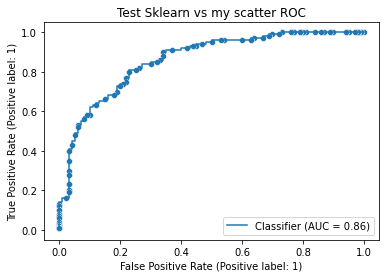

In [481]:
def plot_roc(data, x="FPR", y="TPR", n_thresholds=100, ax=None, title="", color_thresholds=True):
    metrics_df = get_metrics(data, n_thresholds=n_thresholds)
    kwargs = {"hue": "threshold", "palette": "coolwarm"} if color_thresholds else {}
    ax = sns.scatterplot(data=metrics_df, x=x, y=y, ax=ax, **kwargs)
    ax.set_title(title)
    
# test my roc and sklearn
data = get_data(overlap=0.5, dist="normal")
sk_metrics.RocCurveDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"])
plot_roc(data, color_thresholds=False)
plt.title("Test Sklearn vs my scatter ROC")
plt.show()

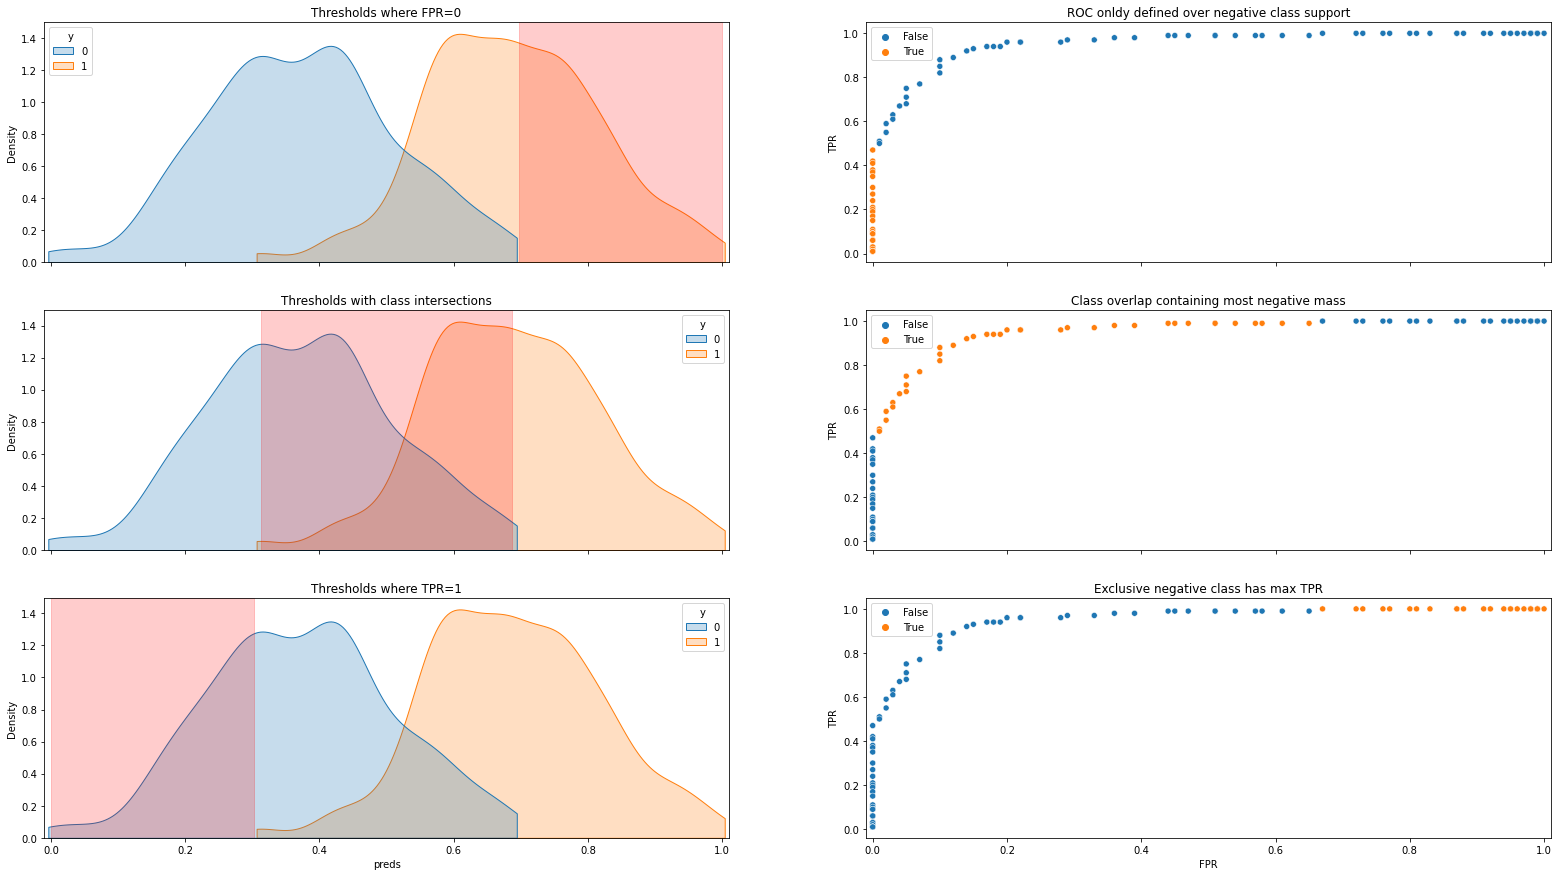

In [5]:
fig, axarr = plt.subplots(3, 2, figsize=(27, 15), sharex=True)
data = get_data(overlap=0.4, dist="normal")
metrics_df = get_metrics(data, n_thresholds=100)

fpr0_th = metrics_df.query("FPR == 0")["FPR"].index
plot_data(data, ax=axarr[0, 0], title="Thresholds where FPR=0", dist="normal")
axarr[0, 0].axvspan(fpr0_th.min(), fpr0_th.max(), alpha=0.2, color="red")
sns.scatterplot(data=metrics_df, x="FPR", y="TPR", hue=metrics_df.index.isin(fpr0_th) , ax=axarr[0, 1])
axarr[0, 1].set_title("ROC onldy defined over negative class support")

mid_th = metrics_df.query("TPR < 1").query("FPR > 0")["FPR"].index
plot_data(data, ax=axarr[1, 0], title="Thresholds with class intersections", dist="normal")
axarr[1, 0].axvspan(mid_th.min(), mid_th.max(), alpha=0.2, color="red")
sns.scatterplot(data=metrics_df, x="FPR", y="TPR", hue=metrics_df.index.isin(mid_th) , ax=axarr[1, 1])
axarr[1, 1].set_title("Class overlap containing most negative mass")

tpr1_th = metrics_df.query("TPR == 1")["FPR"].index
plot_data(data, ax=axarr[2, 0], title="Thresholds where TPR=1", dist="normal")
axarr[2, 0].axvspan(tpr1_th.min(), tpr1_th.max(), alpha=0.2, color="red")
sns.scatterplot(data=metrics_df, x="FPR", y="TPR", hue=metrics_df.index.isin(tpr1_th) , ax=axarr[2, 1])
axarr[2, 1].set_title("Exclusive negative class has max TPR")

plt.xlim(-0.01, 1.01)
plt.show()

Normal


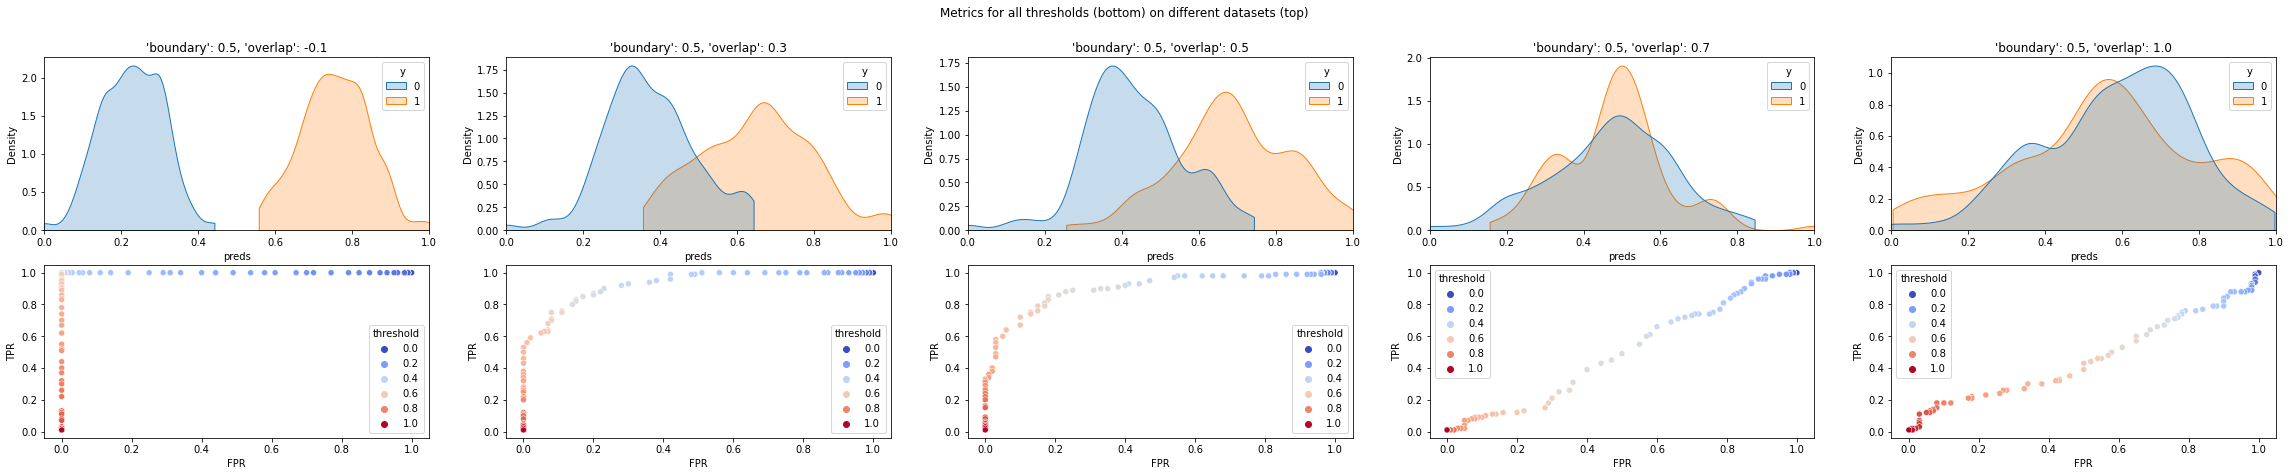

In [473]:
examples = [
        {"boundary": 0.5, "overlap": -0.1},
        {"boundary": 0.5, "overlap": 0.3},
        {"boundary": 0.5, "overlap": 0.5},
        {"boundary": 0.5, "overlap": 0.7},
        {"boundary": 0.5, "overlap": 1.0},
    ]

print("Normal")
fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=False)
plt.suptitle("Metrics for all thresholds (bottom) on different datasets (top)")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="normal")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="normal")
    plot_roc(data, ax=axarr[1, ix])
plt.show()

## 3. AUROC
- Area under the ROC curve
- By reducing a vector to a single number we necessarily lose information
- Different ROC curves will inevitably produce the same scores
- Here we explore some invariances of the AUROC wrt the underlying data
- Notice: The right side of the decision space (shaded above), where there is no support for the negative class (FPR=0), does not contribute
- The Area is maximised the fewer positives are on the support of the negative class

### 3.1 Scale Invariance
- We can shrink the support of the dataset/predictions and see if AUROC changes
- AUROC is scale invariant
- ROC traverses the FPR space linearly, regardless of where and how spread out it is
- Because the scaling is uniform all "extra" thresholds will map to the same FPR and TPR anyways, so the ROC curve will remae unchanged
- Thresholds left of the negative class will collapse to FPR=1 (no TN, all negative classes are FP), while thresholds right of the negative class (and positive class) will collapse to FPR=0 (no FP, all negative classes are TN)

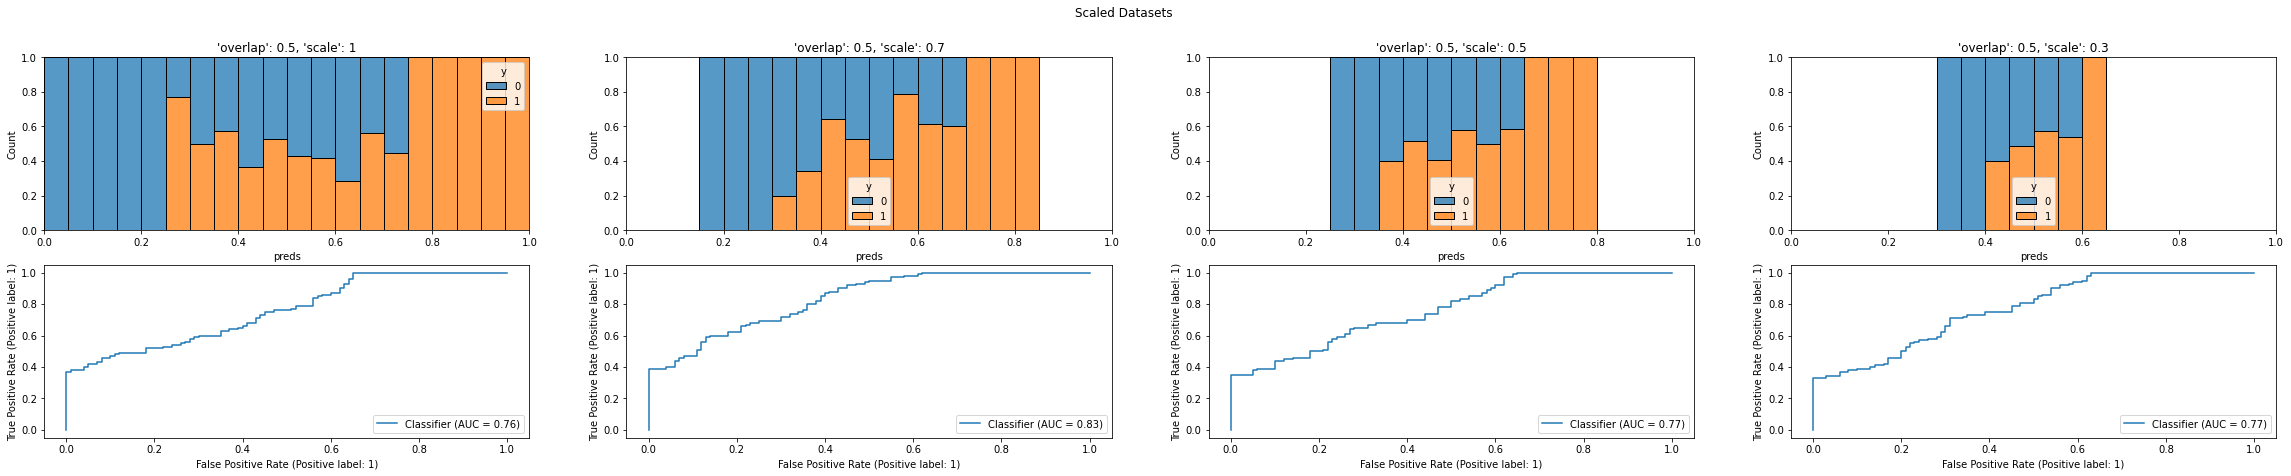

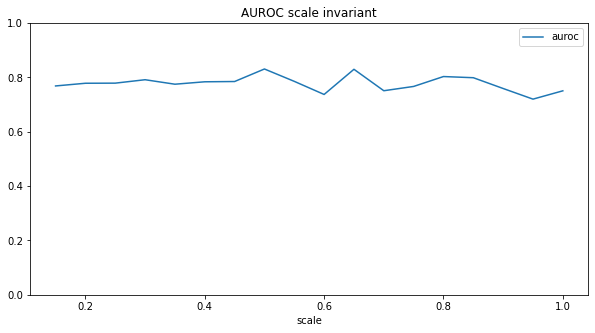

In [597]:
examples = [{"overlap": 0.5, "scale": i} for i in [1, 0.7, 0.5, 0.3]]

fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=False)
plt.suptitle("Scaled Datasets")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    sk_metrics.RocCurveDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"], ax=axarr[1, ix])
plt.show()


res = []
for scale in np.arange(1, 0.1, -0.05):
    data = get_data(overlap=0.5, scale=scale, dist="uniform")
    res.append({
        "scale": scale, 
        "auroc": sk_metrics.roc_auc_score(data["y"], data["preds"])
    })
pd.DataFrame(res).set_index("scale").plot(figsize=(10, 5), ylim=(0, 1), title="AUROC scale invariant")
plt.show()

### 3.2 Shift Invariance
- We can shift the predictions e.g squeeze them all into [0.5, 1]
- AUROC is shift invariant
- ROC traverses the FPR space linearly, regardless of where and how spread out it is
- Similar to scale invariance, it doesn't really matter where the prediction interval is located, all thresholds left and right of the negative class support will collapse to a single point respectively on the ROC curve; all other thresholds will produce FPR and TRPs that have been seen before as all the ratios are the same

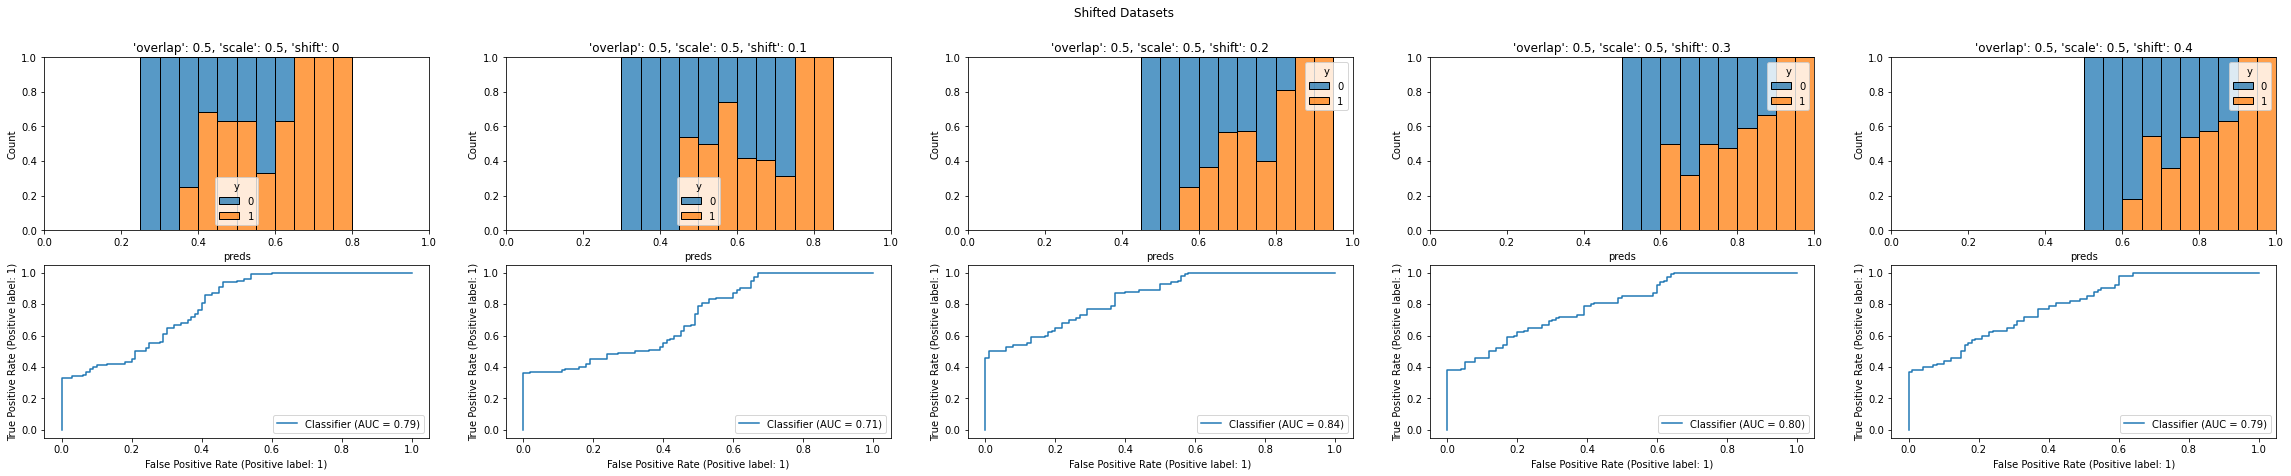

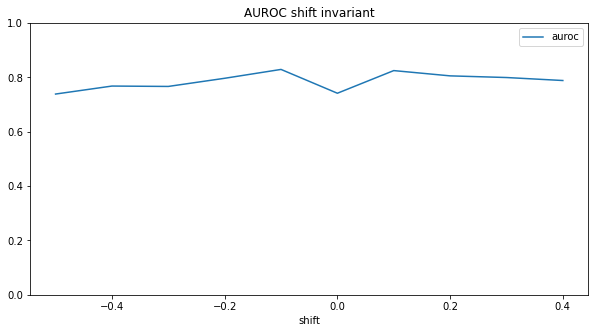

In [598]:
examples = [{"overlap": 0.5, "scale": 0.5, "shift": i} for i in [0, .1, .2, .3, .4]]

fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=False)
plt.suptitle("Shifted Datasets")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    sk_metrics.RocCurveDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"], ax=axarr[1, ix])
plt.show()


res = []
for shift in np.arange(-0.5, 0.5, 0.1):
    data = get_data(overlap=0.5, scale=0.5, shift=shift, dist="uniform")
    res.append({
        "shift": shift, 
        "auroc": sk_metrics.roc_auc_score(data["y"], data["preds"])
    })
pd.DataFrame(res).set_index("shift").plot(figsize=(10, 5), ylim=(0, 1), title="AUROC shift invariant")
plt.show()

### 3.3. Class Boundary and Margin Sensitivity
- How sensitive is AUROC to different degrees of predictions overlapping
- When there is a clear separation between classes e.g a wide margin, then AUROC maxes out since for all thresholds over the negative class (all posible FPR rates) we always get full recall (all TP)
- AUROC is sensitive to class overlap, proportional to the mass of positives and negatives in that region
- The more negative mass is outside the overlap the less the margin will be zoomed in
- the more positive mass is in the overlap the more TRP will be compromised

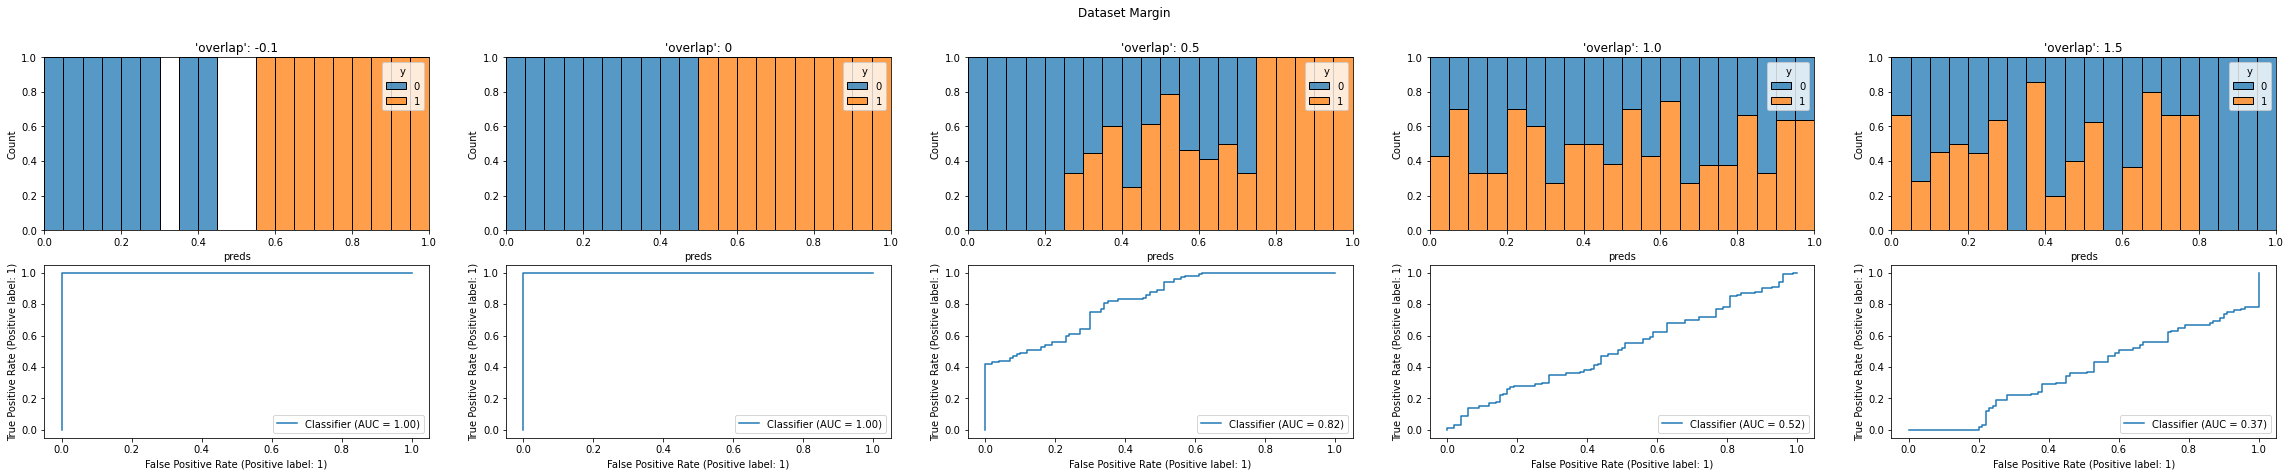

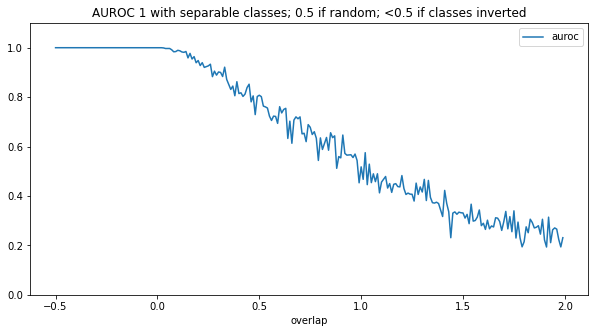

In [633]:
examples = [{"overlap": i} for i in [-0.1, 0, 0.5, 1.0, 1.5]]

fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=False)
plt.suptitle("Dataset Margin")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    sk_metrics.RocCurveDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"], ax=axarr[1, ix])
plt.show()


res = []
for overlap in np.arange(-0.5, 2, 0.01):
    data = get_data(overlap=overlap, dist="uniform")
    res.append({
        "overlap": overlap, 
        "auroc": sk_metrics.roc_auc_score(data["y"], data["preds"])
    })
pd.DataFrame(res).set_index("overlap").plot(figsize=(10, 5), ylim=(0, 1.1), title="AUROC 1 with separable classes; 0.5 if random; <0.5 if classes inverted")
plt.show()

### 3.4 Class Imbalance
- AUROC is invariant to class imbalances
- Both TPR and FPR are ratios of their own class e.g TPR is ratio of predicted positives over all positives
- Nothing in AUROC takes into consideration the ratio of one class to the other
- Both metrics are "inward" looking and the ratios will stay the same regardless of how many total positives or negatives there are

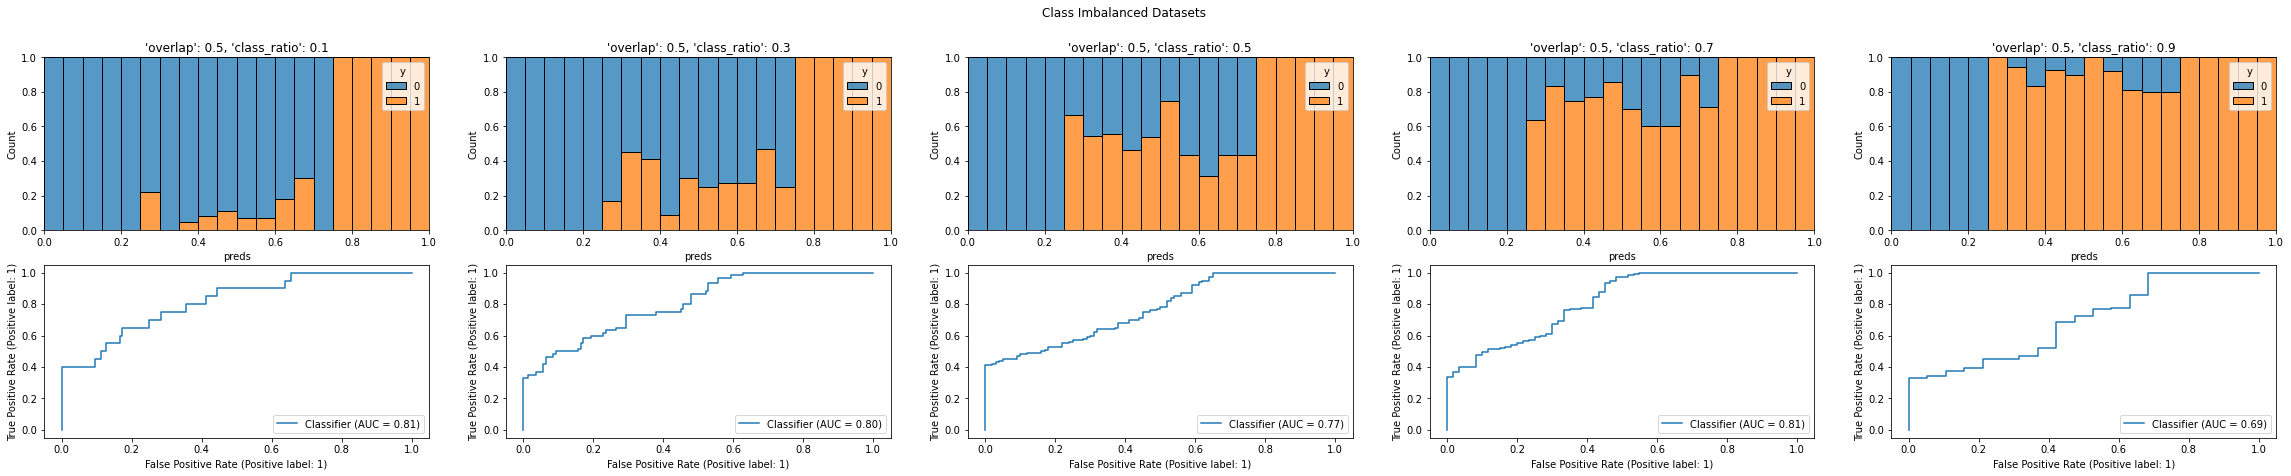

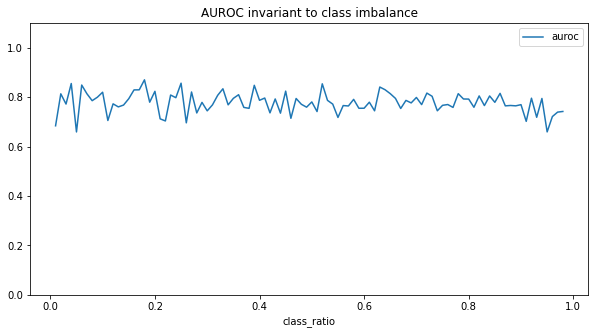

In [637]:
examples = [{"overlap": 0.5, "class_ratio" : i} for i in [.1, .3, .5, .7, .9]]

fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=False)
plt.suptitle("Class Imbalanced Datasets")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    sk_metrics.RocCurveDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"], ax=axarr[1, ix])
plt.show()


res = []
for class_ratio in np.arange(0.01, 0.99, 0.01):
    data = get_data(class_ratio=class_ratio, overlap=0.5, dist="uniform")
    res.append({
        "class_ratio": class_ratio, 
        "auroc": sk_metrics.roc_auc_score(data["y"], data["preds"])
    })
pd.DataFrame(res).set_index("class_ratio").plot(figsize=(10, 5), ylim=(0, 1.1), title="AUROC invariant to class imbalance")
plt.show()

## 4. Limitations
- Consequences of the projection and metric choices
- We can mix parameters and find datasets that have different characteristics but the same AUROC
- Two factors influence AUROC: how much negative mass does not have positives; how much positive mass is in the overlap.

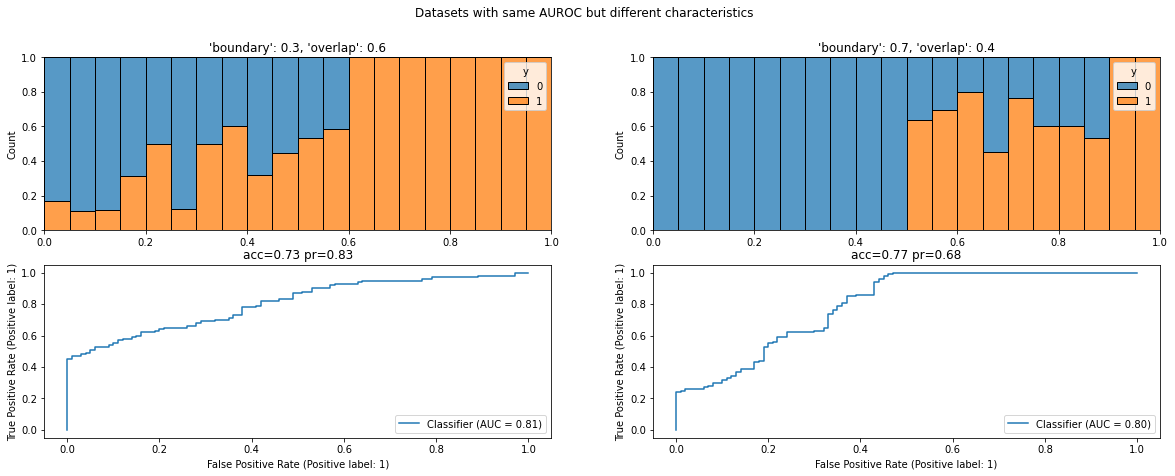

In [45]:
examples = [
    {"boundary": 0.3, "overlap": 0.6},
    {"boundary": 0.7, "overlap": 0.4},
]

fig, axarr = plt.subplots(2, len(examples), figsize=(20,7), sharex=False)
plt.suptitle("Datasets with same AUROC but different characteristics")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    axarr[0, ix].set_xlabel("")
    
    axarr[1, ix].set_title(f"acc={sk_metrics.accuracy_score(data['y'], data['preds'] > 0.5):.2f} pr={sk_metrics.precision_score(data['y'], data['preds'] > 0.5):.2f}")
    sk_metrics.RocCurveDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"], ax=axarr[1, ix])
plt.show()


# 5. Conclusion
- AUROC measures the expected recall for decision thresholds placed over the negative class support
- The underlying metrics TPR and FPR are class independent and don't provide any information about inter-class ratios, hence its invariance to class imbalance
- The ROC curve displays TPR as a function of FPR; the invidual threshold values are lated. Threshold traversal is non-linear as some intervals are collapsed or expanded, but negative class traversal is linear.
- Depending on where most negative mass is, ROC either zooms in on the exlusive negative zone (max TPR) or on the class boundary
- AUROC is invariant to: scale, shift of the prediction space; and class imbalances
- AUROC it is maximised when there is a clear separation, minimised when classes overlap entirely.